### Bayesian Analysis of Terror Attacks

The Global Terrorism Database is a data set of over 150,000 terror attacks from 1970 - 2015 that is maintained by START at the University of Maryland. Considering I had a minor in Global Terrorism through START while I was an undergrad at UMD, I was excited for the opportunity to use the data that START had just open sourced through Kaggle. The data has 137 columns, detailing things like the location, type, perpetrator, and target of the attack. Many of these columns are nearly all null, and all data for 1993 has been lost.

This assignment had two tasks:
1. Complete a Bayesian analysis to compare two different populations
2. Impute the number of bombings in 1993

First, import all necessary libraries and read in the dataset

In [1]:
# standard libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# for Bayesian analysis
import pymc3 as pm

# cleaning up the notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../../../Data/globalterrorismdb_0616dist.csv')
print(df.head())

        eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       0     0        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region   ...    addnotes scite1 scite2  scite3  \
0  Dominican Republic       2   ...         NaN    NaN    NaN     NaN   
1              Mexico       1   ...         NaN    NaN    NaN     NaN   
2         Philippines       5   ...         NaN    NaN    NaN     NaN   
3              Greece       8   ...         NaN    NaN    NaN     NaN   
4               Japan       4   ...         NaN    NaN    NaN     NaN   

   dbsource  INT_LOG  INT_IDEO INT_MISC INT_ANY  related  
0      PGIS    

The data is too big to determine exactly what columns are usable for our analysis (137 columns with over 150,000 records. Kaggle did provide a data dictionary for this dataset to allow us to determine what columns may be most useful for this analysis.

In [3]:
# The below code will not show the data type for most columns, nor will it show null counts for most columns
print df.dtypes
print df.isnull().sum()

eventid                 int64
iyear                   int64
imonth                  int64
iday                    int64
approxdate             object
extended                int64
resolution             object
country                 int64
country_txt            object
region                  int64
region_txt             object
provstate              object
city                   object
latitude              float64
longitude             float64
specificity             int64
vicinity                int64
location               object
summary                object
crit1                   int64
crit2                   int64
crit3                   int64
doubtterr             float64
alternative           float64
alternative_txt        object
multiple                int64
success                 int64
suicide                 int64
attacktype1             int64
attacktype1_txt        object
                       ...   
propextent            float64
propextent_txt         object
propvalue 

### Bayesian Comparison of Different Populations

I was tasked with comparing two different populations using Bayesian inference. To select two different populations, I reviewed each region as coded by the GTD to determine a suitable group that could be used to compare different groups over a certain time frame. For this, I looked for a fairly consistent number of terror attacks over an extended period of time within a region.

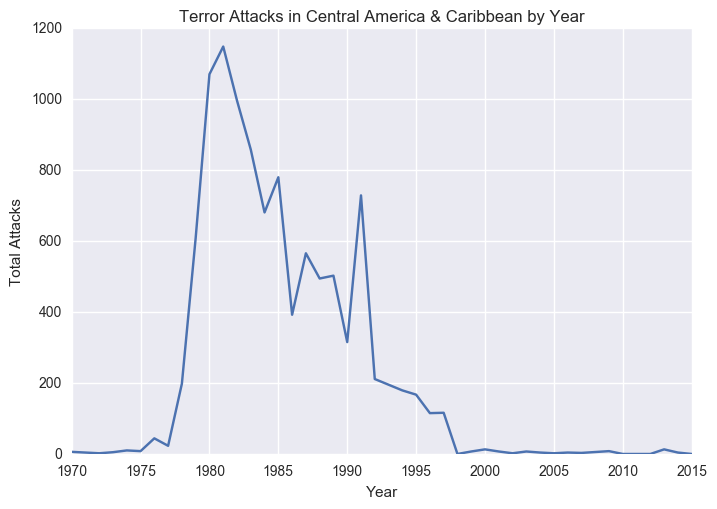

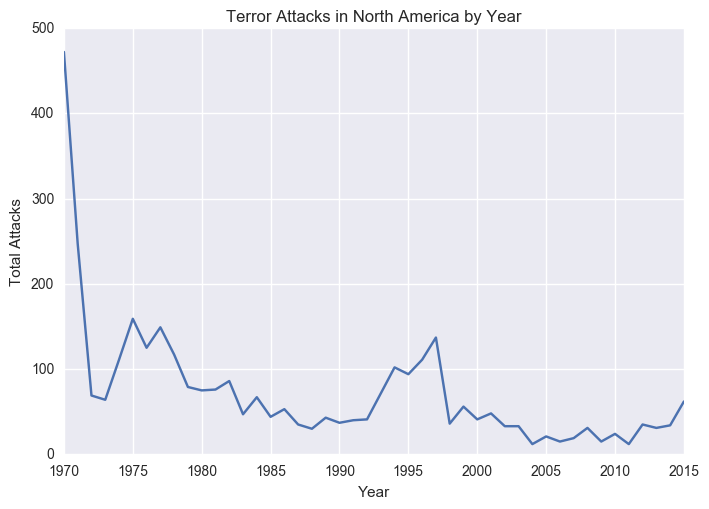

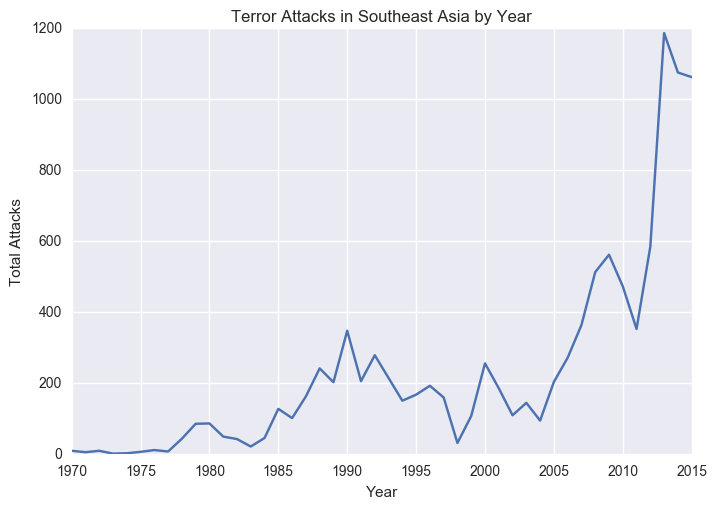

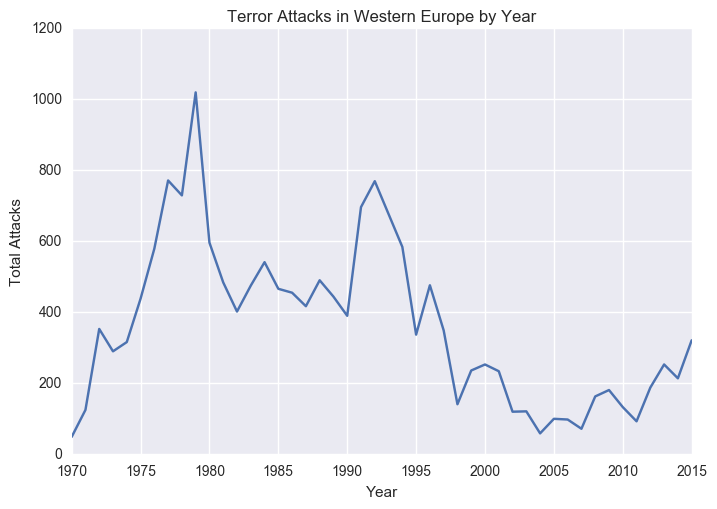

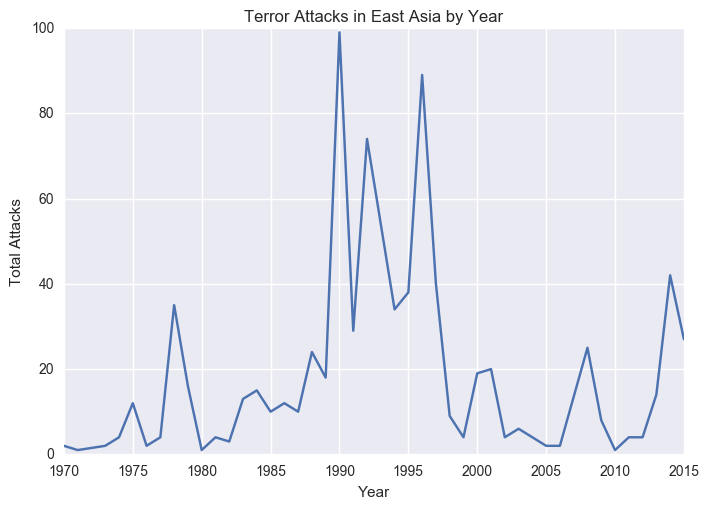

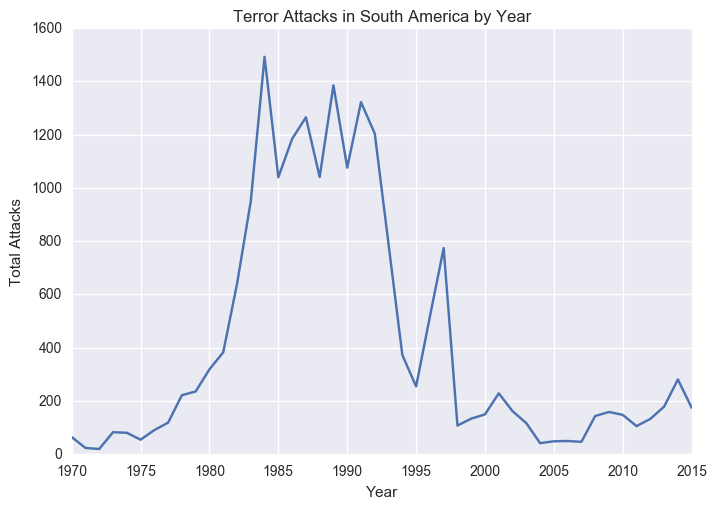

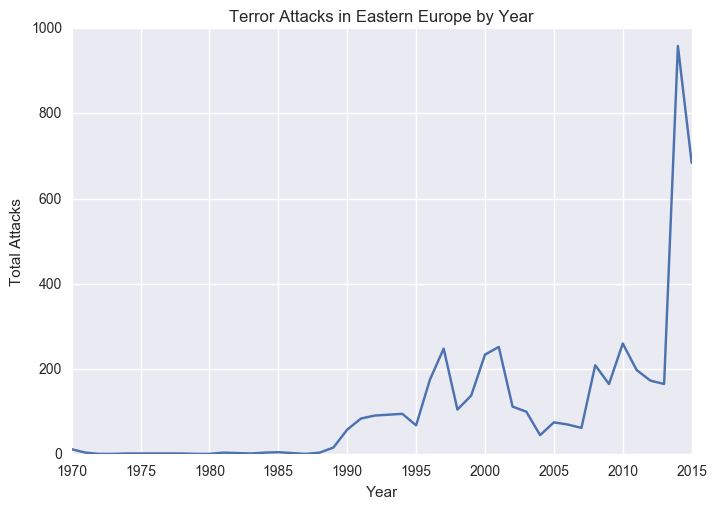

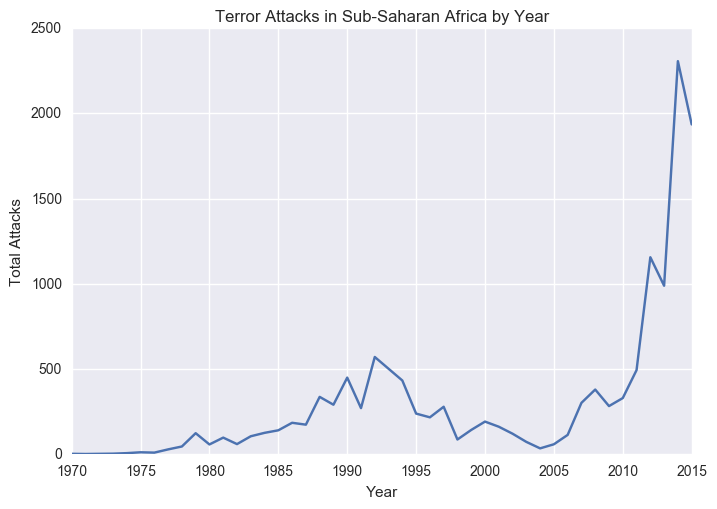

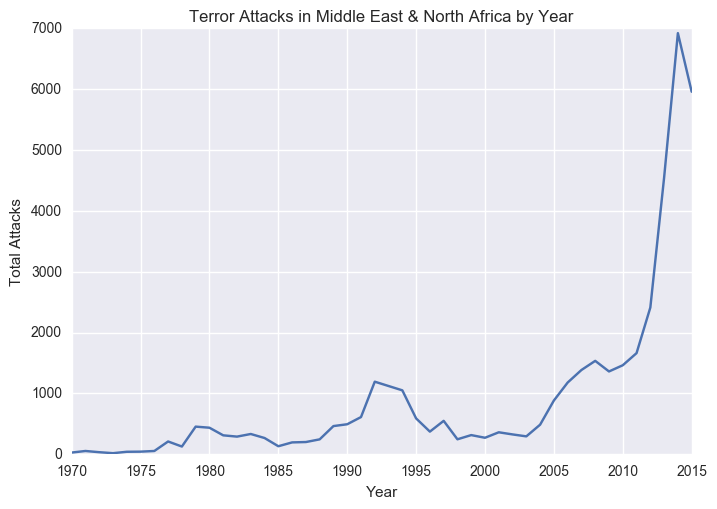

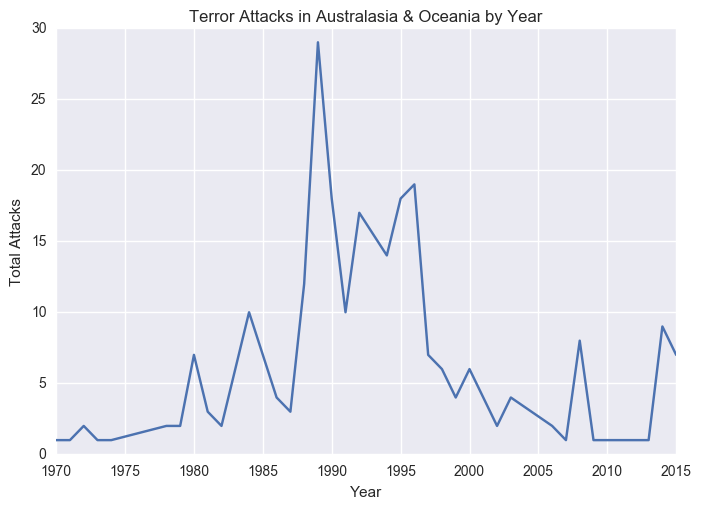

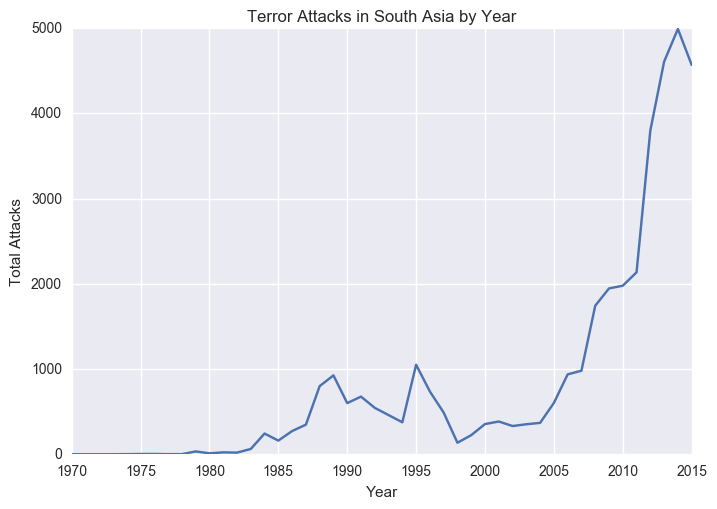

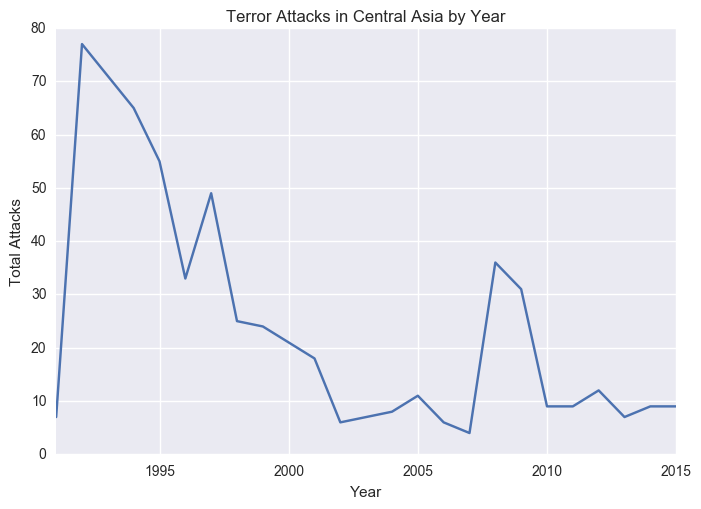

In [4]:
regions = df.region_txt.unique()
#print regions

for region in regions:
    df[df.region_txt == region].groupby('iyear').eventid.count().plot(kind = 'line')
    plt.title('Terror Attacks in %s by Year' % (region))
    plt.xlabel('Year')
    plt.ylabel('Total Attacks')
    plt.show()

Based on the graphs produced above, I decided to use Western Europe as a region to compare countries within. They had an extended period of elevated terror attacks from the early 1970s until the late 1990s, so I decided to see if there were two countries in Western Europe that could be considered statistically different from one another during this time period based on the number of terror attacks within the country each year. I also decided to limit the type of attacks to bombings, since it was the most common type of attack.

In [5]:
# Attack type is one column that will be necessary
print('Counts of Attack Types:')
print(df.attacktype1.value_counts())
print('Attack Type Count Text:')
print(df.attacktype1_txt.value_counts())

Counts of Attack Types:
3    75963
2    37554
1    17582
6     9115
7     8849
9     5490
5      835
8      828
4      556
Name: attacktype1, dtype: int64
Attack Type Count Text:
Bombing/Explosion                      75963
Armed Assault                          37554
Assassination                          17582
Hostage Taking (Kidnapping)             9115
Facility/Infrastructure Attack          8849
Unknown                                 5490
Hostage Taking (Barricade Incident)      835
Unarmed Assault                          828
Hijacking                                556
Name: attacktype1_txt, dtype: int64


In [6]:
## create dataframe of just attacks that are bombings
df_bomb = df[df.attacktype1 == 3]

## remove most unnecessarsy columns
df_bomb_2 = df_bomb[['eventid','iyear','imonth','iday','country','country_txt','region','region_txt']]

## getting individual bombing events in Western Europe from 1975 - 1996, period of elevated bombings
we_bomb_80 = df_bomb_2[(df_bomb_2.region == 8) & (df_bomb_2.iyear >= 1975) & (df_bomb_2.iyear <= 1996)]

## dataframes for UK and Spain after decrease in bombings in W. Europe
UK_bomb_96 = df_bomb_2[(df_bomb_2.country_txt == 'United Kingdom') & (df_bomb_2.iyear >= 1997) & (df_bomb_2.iyear <= 2000)]
ESP_bomb_96 = df_bomb_2[(df_bomb_2.country_txt == 'Spain') & (df_bomb_2.iyear >= 1997) & (df_bomb_2.iyear <= 2000)]

## bombings by year in each
UK_observed = UK_bomb_96.iyear.value_counts()
ESP_observed = ESP_bomb_96.iyear.value_counts()

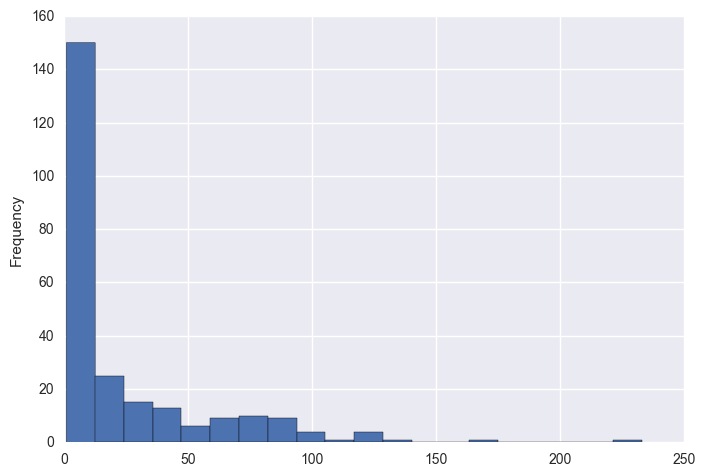

In [7]:
## Distribution of attacks in W. European country by year in 1980s

we_bomb_80.groupby(['iyear','country']).eventid.count().plot.hist(bins = 20)
plt.show()

In [8]:
## Mean and Standard Deviation of total counts of bombings by country & year for W. European countries in 1980s

mean_prior_mean = np.mean(we_bomb_80.groupby(['iyear','country']).eventid.count())
mean_prior_std = np.std(we_bomb_80.groupby(['iyear','country']).eventid.count())

In [9]:
## Setting priors for both countries
## Normally distributed since there are enough countries + years to assume normality

with pm.Model() as model:

    UK_mean = pm.Normal('UK_mean', mean_prior_mean, sd=mean_prior_std)
    ESP_mean = pm.Normal('ESP_mean', mean_prior_mean, sd=mean_prior_std)

In [10]:
## Setting upper and lower prior Standard Devs - observed counts as low as 1 and as high as ~120 in prior dataset

std_prior_lower = 0.01
std_prior_upper = 120.0

with model:
    
    UK_std = pm.Uniform('UK_std', lower=std_prior_lower, upper=std_prior_upper)
    ESP_std = pm.Uniform('ESP_std', lower=std_prior_lower, upper=std_prior_upper)

In [11]:
## Setting up posterior distributions of bombings for two countries

with model:

    group_UK = pm.Normal('UK_Bomb', mu=UK_mean, sd=UK_std, observed=UK_observed.values)
    group_ESP = pm.Normal('ESP_Bomb', mu=ESP_mean, sd=ESP_std, observed=ESP_observed.values)
    
## Get range of values in late 90s as observed values (bombings from 1997 - 2000)

In [12]:
### Additional deterministic measures to compare two groups

with model:

    diff_of_means = pm.Deterministic('difference of means', UK_mean - ESP_mean)
    diff_of_stds = pm.Deterministic('difference of stds', UK_std - ESP_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((UK_std**2 + ESP_std**2) / 2))

In [13]:
## start fitting model w MCMC
with model:
    trace = pm.sample(25000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -36.913: 100%|██████████| 200000/200000 [00:17<00:00, 11314.66it/s]
Finished [100%]: Average ELBO = -36.869
100%|██████████| 25000/25000 [00:53<00:00, 466.63it/s]


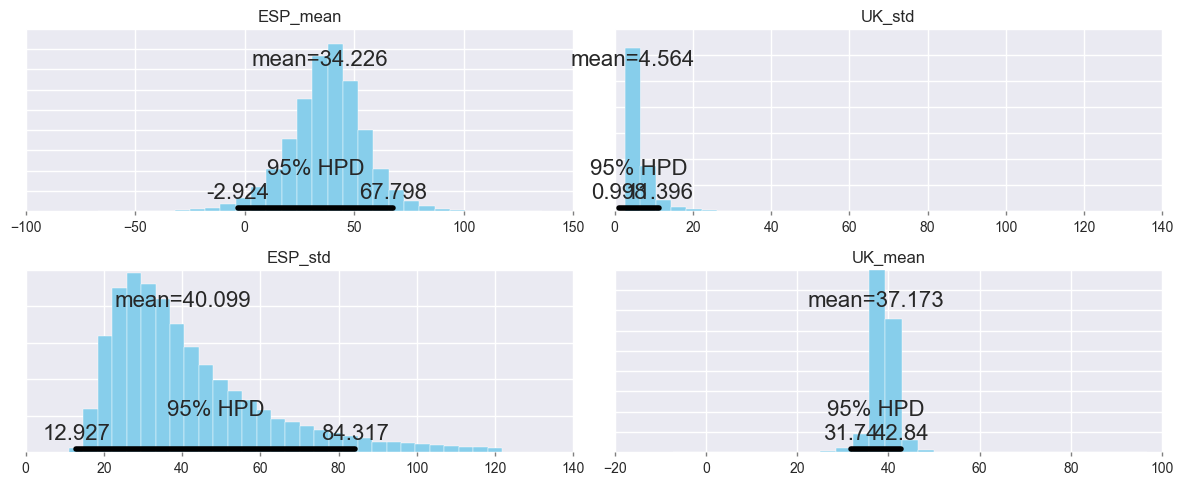

In [14]:
## Plotting posteriors and result distributions

pm.plot_posterior(trace[3000:],
                  varnames=['UK_mean', 'ESP_mean', 'UK_std', 'ESP_std'],
                  color='#87ceeb')
plt.show()

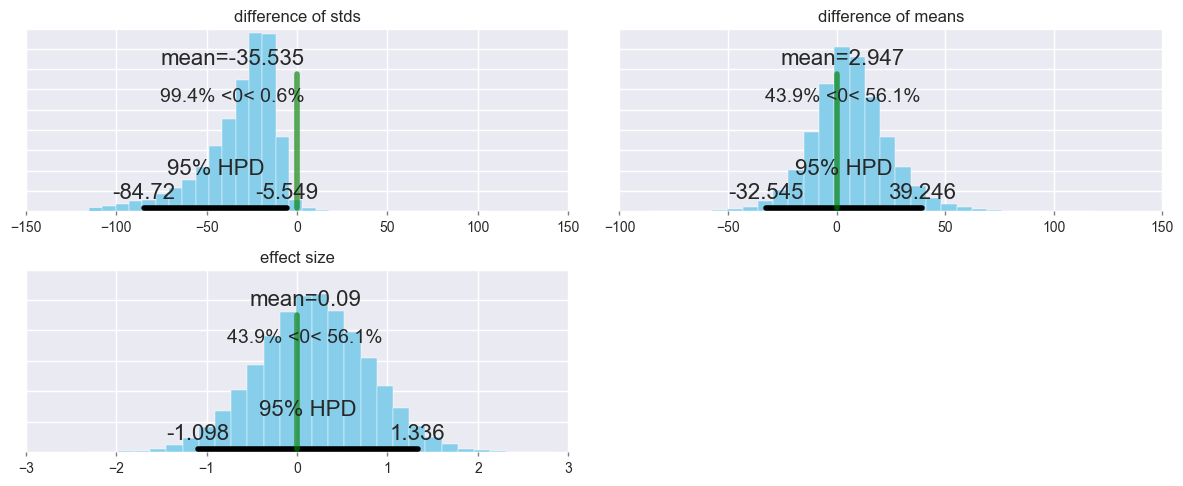

In [15]:
pm.plot_posterior(trace[3000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')
plt.show()

In both cases (The United Kingdom and Spain) for the number of bombings from 1997 - 2000 using a prior distribution of bombings in Western Europe from 1975 - 1996, our posterior distributions are not statistically different. For the difference of the two means and standard deviations of the two posteriors, the value '0' falls in the 95% credible interval. This is the case for the effect size as well, the normalized measure of the differences between the two posteriors.

### 1993 Bombing Calculation

The second task was to calculate the number of bombings that occurred in 1993, since all data was lost from this year. First, I looked at the number of bombings over years to determine if there was any pattern.

In [16]:
df_bomb.iyear.value_counts().sort_index()

1970     333
1971     238
1972     186
1973     149
1974     284
1975     370
1976     419
1977     635
1978     644
1979    1057
1980     997
1981    1082
1982    1125
1983    1246
1984    1775
1985    1482
1986    1506
1987    1476
1988    1650
1989    1797
1990    1731
1991    1988
1992    1738
1994    1153
1995     791
1996    1217
1997    1123
1998     504
1999     652
2000     904
2001     802
2002     721
2003     678
2004     655
2005    1064
2006    1502
2007    1865
2008    2642
2009    2565
2010    2507
2011    2587
2012    5080
2013    6669
2014    8759
2015    7615
Name: iyear, dtype: int64

The same information printed above is plotted over time below, with marks at both 1992 and 1994 on the line to show about where the estimate needs to look.

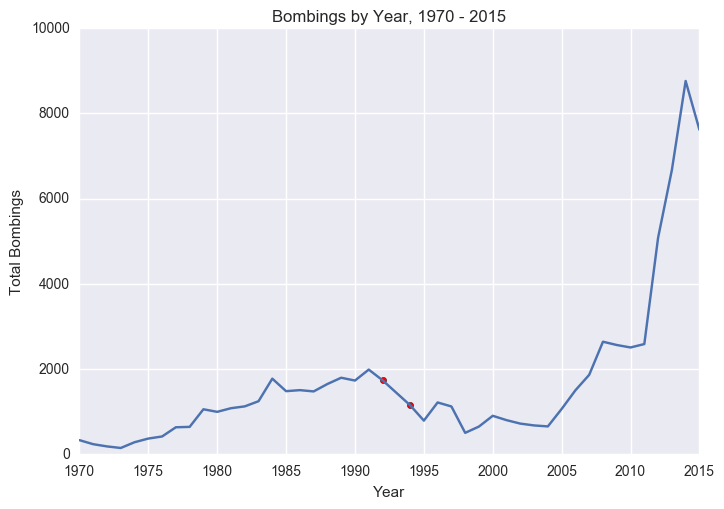

In [17]:
plt.plot(df_bomb.iyear.value_counts().sort_index())
plt.scatter([1992, 1994], [1738, 1153], c = 'red')
plt.xlabel('Year')
plt.ylabel('Total Bombings')
plt.title('Bombings by Year, 1970 - 2015')
plt.xlim([1970,2015])
plt.ylim([0,10000])
plt.show()

There is a slow upward trend of bombings from the beginning of data collection in 1970 until the early 90s, and then a slow gradual drop through the rest of the 90s. It will be most effective to calculate a rolling mean that captures the peak in bombings in 1992, and then the decrease throughout the 90s. With this rolling mean trend line created, we can calculate the number of bombings in 1993 by taking the mean of the rolling mean values between 1992 and 1993.

In [18]:
## create the years to look over
years = np.arange(1977, 1998)

## drop attacks where month is unassigned
bombing = df_bomb_2[(df_bomb_2.iyear.isin(years)) & (df_bomb_2.imonth != 0)].groupby('iyear').eventid.count().sort_index()
print bombing

iyear
1977     630
1978     644
1979    1057
1980     997
1981    1082
1982    1124
1983    1246
1984    1775
1985    1482
1986    1506
1987    1476
1988    1650
1989    1797
1990    1731
1991    1988
1992    1738
1994    1153
1995     791
1996    1217
1997    1123
Name: eventid, dtype: int64


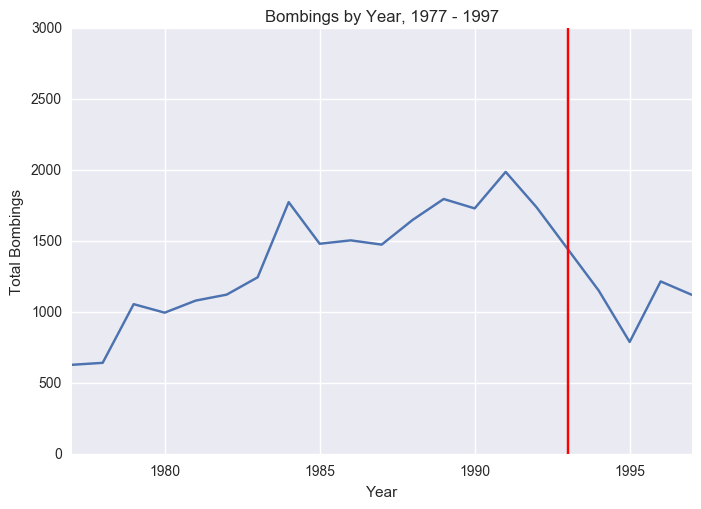

In [19]:
## Visualize the time series of years of interest

plt.plot(bombing)
plt.xlabel('Year')
plt.ylabel('Total Bombings')
plt.title('Bombings by Year, 1977 - 1997')
plt.xlim([1977,1997])
plt.ylim([0,3000])
plt.axvline(x = 1993, c = 'red')
plt.show()

In [21]:
## Import libraries necessary to plot smoothed bombings
## Due to not having any pattern in autocorrelation, ultimately did not calculate any time series to impute 1993 values

%matplotlib inline
import datetime
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

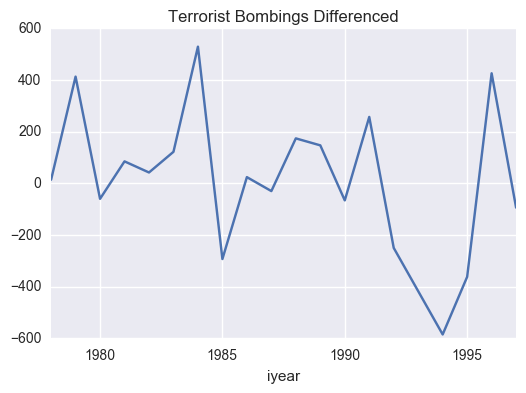

In [24]:
## This would need to be smoother to calculate an ARIMA or anything time series related to get 1993 values.

diff0 = bombing.diff(periods=1)[1:]
diff0.plot(title='Terrorist Bombings Differenced')

In [22]:
## This is a function to plot smoothed rolling mean next to original data with rolling mean window as an argument

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=window)
    rolstd = pd.rolling_std(timeseries, window=window)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Bombings')
    plt.ylabel('Year')
    plt.axvline(x = 1993, c = 'green')
    plt.show()
    

Below, we will plot the rolling mean values that will be used to calculate 1993's number of bombings. We will use a lookback window of 4 years to smooth out any random spikes that occur over time, and get a more general line to capture these trends over the time period of interest.

In [26]:
## Pandas has rolling mean function
pd.rolling_mean(bombing, 4)

iyear
1977        NaN
1978        NaN
1979        NaN
1980     832.00
1981     945.00
1982    1065.00
1983    1112.25
1984    1306.75
1985    1406.75
1986    1502.25
1987    1559.75
1988    1528.50
1989    1607.25
1990    1663.50
1991    1791.50
1992    1813.50
1994    1652.50
1995    1417.50
1996    1224.75
1997    1071.00
Name: eventid, dtype: float64

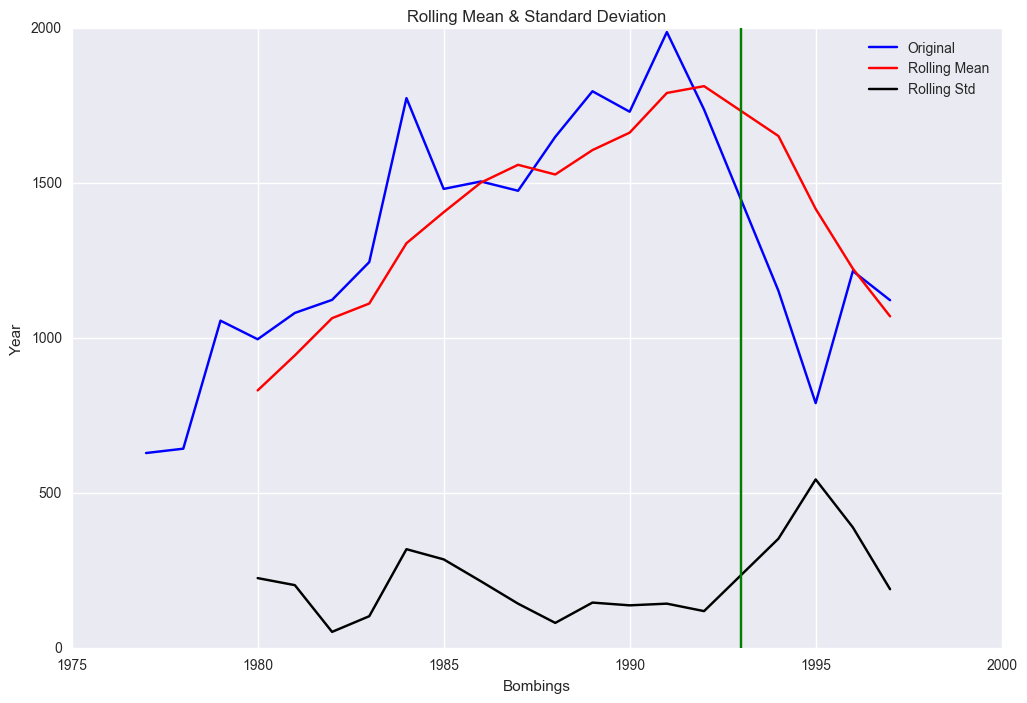

In [27]:
## Using the function created above to show this visually
test_stationarity(bombing, 4)

Below, we estimate the number of bombings in 1993 by averaging the rolling mean value from 1992 and 1994. This should be around the value where the green vertical line in the graph above intersects the red Rolling Mean trend.

In [31]:
print "The estimated number of bombings in 1993 is {}".format(((pd.rolling_mean(bombing, 4).loc[1992]) + (pd.rolling_mean(bombing, 4).loc[1994])) / 2)

The estimated number of bombings in 1993 is 1733.0
